![Image of Yaktocat](sendy.jpg)

# Sendy Logistics Regression Model
<br></br>


## Introduction

Sendy is a business-to-business platform established in 2014, to enable businesses of all types and sizes to transport goods more efficiently across East Africa.

Logistics is fundamental to the success of a business while efficient and affordable logistics are a vital component of economic development. To help Sendy achieve affordability and effieciency, a prediction of the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination is made. This prediction will enhance customer communication and improve the reliability of its service; which will ultimately improve customer experience.

The prediction will enable Sendy to realise cost savings, and ultimately reduce the cost of doing business, through improved resource management and planning for order scheduling. The accurate arrival time prediction will help all businesses involved to improve their logistics and communicate an accurate time to their customers.

## Importing the Libraries

In [ ]:
import numpy as np 
import math
# data processing
import pandas as pd 

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn import tree
from sklearn.model_selection import GridSearchCV

## Getting the Data

In [ ]:
# the csv files are converted to panda dataframe and are renamed.
Train_df= pd.read_csv("Train.csv")
Test_df= pd.read_csv("Test.csv")
Riders_df= pd.read_csv("Riders.csv")
VariableDefinitions_df= pd.read_csv("VariableDefinitions.csv")
SampleSubmission_df= pd.read_csv("SampleSubmission.csv")


## Data Description

Exploring data sets helps in developing deep understanding about the data, the data set is Explored with imported libraries.The Variable dataframe below displays the name of features and desciptions on the right.

In [ ]:
VariableDefinitions_df

The dataframe above is the list of the features with a short description:

In [ ]:
VariableDefinitions_df.info()

In [ ]:
#Train data set
Train_df.info()

The training-set has 21201 entries and 28 features + the target variable (Time from Pickup to Arrival). 6 of the features are floats, 13 are integers and 10 are objects.Since there is a Train data set, this implies that the data has been split and any aditing that will be done on the train data set will also be applied on the Test data set.

In [ ]:
Train_df.head(8)

From the table above,few things can be noted. some of the features need to be converted into numeric ones, so that the machine learning algorithms can process them. Furthermore. Some more features, that contain missing values (NaN = not a number) can also be spoted, that would be deal with later on.

In [ ]:
Train_df.columns.values

Above are all features present in the Train data frame

In [ ]:
    # Rider data set
Riders_df.info()

Rider_df displays the information about the motorbike riders. It consist of 5 features and 960 entries.

In [ ]:
Riders_df.head(8)

Above is the overview of the Riders data frame. The feature (Rider Id) is common to both Riders and Train Data Frame this allows for a merge between the two data frames.

In [ ]:
#features found within the Rider data set.
Riders_df.columns.values

In [ ]:
    #a look at the submission sample data frame
SampleSubmission_df.head(8)

The sample submission displays the format in which sumbmision would be made for this predict on Zindi

## Data cleaning and formating

#### __Data cleaning__

In [ ]:
    #Joining the riders to both Train and Test data set
Train_df = pd.merge(Train_df, Riders_df, left_on='Rider Id', 
                    right_on='Rider Id', how='left')
Test_df = pd.merge(Train_df, Riders_df, left_on='Rider Id',
                    right_on='Rider Id', how='left')

Test and Train data frames are merged with Riders data data frame on the Rider Id feature.

In [ ]:
Train_df.head(8)

Above is the new merged Train data set and The same is be done for the Test data set. For the purpose of this predict, the Vehicle Type feature is dropped because only motor bikes are considered. The naming format is not consistant in the above data frame(under scores will be use instead of spaces)

In [ ]:
    # Dropin the  Vehicle Type 
Train_df = Train_df.drop(['Vehicle Type'], axis = 1)
Test_df = Test_df.drop(['Vehicle Type'], axis = 1)

In [ ]:
Test_df.head(8)

In [ ]:
Test_df.head(8)

The Vehicle feature has been succefully droped from both data frames.

In [ ]:
    # Formatting the naming of the columns
Train_df.columns = Train_df.columns.str.replace(' ', '_')
Test_df.columns = Test_df .columns.str.replace(' ', '_')

In [ ]:
    #removing "-" from the feature labels.
Train_df.columns = Train_df.columns.str.replace('_-_', '_')
Train_df = Train_df.rename(columns={"Time_from_Pickup_to_Arrival": "Time from Pickup to Arrival"})
Test_df.columns = Test_df .columns.str.replace('_-_', '_')
Test_df = Test_df.rename(columns={"Time_from_Pickup_to_Arrival": "Time from Pickup to Arrival"})

In [ ]:
Train_df.head(8)

In [ ]:
print('There are', Train_df['Rider_Id'].nunique(), 
      'Motorbike riders', 'and', Train_df['User_Id'].nunique(), 
      'Customers')

__Handling missing data__

In [ ]:
aval_df = Train_df.notnull().sum(axis=0).reset_index()
aval_df.columns = ['column_name', 'missing_count']
aval_df = aval_df.loc[aval_df['missing_count']>0]
aval_df = aval_df.sort_values(by='missing_count')

ind = np.arange(aval_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,8))
rects = ax.barh(ind, aval_df.missing_count.values, color='magenta')
ax.set_yticks(ind)
ax.set_yticklabels(aval_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Total Count of Available values")
ax.set_ylabel("Features")
ax.set_title("Available Data In Each Column")
plt.show()

The chart above display how much data is available, the full bars means the data for that feature is comple and the last two bar bars are the only ones with missing data.

__More detailed look at what data is actually missing:__

In [ ]:
 #Train_df missing data
total = Train_df.isnull().sum().sort_values(ascending=False)
percent_1 = Train_df.isnull().sum()/Train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

In [ ]:
#Visual Display of missing Data in Train data frame
ax = missing_data['Total'].plot(kind='barh', figsize=(10, 15), color='green', zorder=2, width=0.68)
ax.set_title("Total Count of Missing Data in Features",  labelpad=24, weight='bold', size=18)
ax.set_xlabel("Total count of missing values", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Features", labelpad=20, weight='bold', size=12)

As obseved from both missing_data frame and the visual display above, it will be a bit tricky to deal with the 'Temparature' feature, which has 4366 missing values. However on the other hand, the 'Precipitation in mm' feature needs further investigation, but it looks like it would be better if it is dropped off from the dataset, since 97.4 % of it is missing data.

*Investigating on Precipitation in millimeter feature.*

In [ ]:
    #Checking if there are 0 mm records of Precipitation from both Test and Train data frame
(Train_df['Precipitation_in_millimeters']==0).all(),(Test_df['Precipitation_in_millimeters']==0).all()


The are no Recorded 0 values for precipitation in both of the data frames. It is not likely that pricipitation may occur in all days of the month. So it makes sense that 97% of the time in a month there is no precipitation, therefore the NaN values will be replaced with 0 values.Meaning on those days there was no precipitation.

In [ ]:
    #replacing NAN with 0 for precipitation feature
Train_df["Precipitation_in_millimeters"] = Train_df["Precipitation_in_millimeters"].fillna(0)
Test_df["Precipitation_in_millimeters"] = Test_df["Precipitation_in_millimeters"].fillna(0)

In [ ]:
Train_df.info()

checking from the infomation above, temparature is the only feature with missing values.

Checking for correlation between Temparature and features which may have influence of Time from Pickup to Arrival

In [ ]:
    #Train_df data set 
Temp = sns.boxplot(x="Platform_Type", y="Temperature", hue="Personal_or_Business",
                 data=Train_df, palette="Greens")


The whisker and the box diagram propose that there is a relationship between the temparature and the platform as well as the Personal or bussiness feature. Below is the function, conditional_impute, which performs imputation upon Temperature column within a Pandas DataFrame based upon both Personal or Business and platform.

Data imputation-----------

__*Data formating*__

The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.Below is the fuction that will calculate the disdance between the pickup and destination location.

# EDA

Exploring the features in the data frame

#### A first look at the behaviour of delivery time (Y - Variable)

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(range(Train_df.shape[0]), np.sort(Train_df['Time from Pickup to Arrival'].values), 
            color = 'orange')
plt.xlabel('X - Variables', fontsize=12)
plt.ylabel('Pickup to Arrival Time', fontsize=12)
plt.show()

 ## *Thasamy will add interpretation*

We are going to look at the Platform Type and Business type to look at what makes up most of the orders.

## Understanding The Distribution Of The Data
We are going to look at the features contained in the dataframe independently.This will help with understanding the distribution of the ranges and/or types contained in each.

### Order number, Vehicle Type and User Id

In most cases order numbers are unique numbers assigned to every order made, and we need to check if it the case for this data. We need to look at the vehicle Id to see the types of vehicles we are working with and uder Id to see the total number of users who used this service.

In [ ]:
print('Order numbers:') 
print(Train_df['Order_No'].nunique())
print('User_Id:') 
print(Train_df['User_Id'].nunique())

There are 21201 orders made by 3186 users.

### Categorical data

A look at the Platform Type and Business or Personal features to see at what makes up most of the orders.

In [ ]:
Train_df['Platform_Type'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Platform Type contribution to total orders')
plt.ylabel('')
plt.show()

ax=sns.countplot(x='Personal_or_Business', data=Train_df)
ax.set(xlabel='Personal or Business', ylabel='Number of orders')
plt.show()

From the two figures, one can see that platfrom 3 has the highest numbers of orders and platform 4 has the least numbers. It can also be seen from the barchart that there are more orders for business than there are for personal.

## Numerical data

### Placement and confirmation Day of the month

Placement and confirmation day of the month can be the same. If they are, it will save time that only one of the features is looked at. To check that, a new dataframe is created with rows that pass the condition that confirmation day is the same as placement day of the month. After it is created, if its length is still 21201 then this proves they are the same.

In [ ]:
New_df=Train_df[Train_df['Placement_Day_of_Month']!=Train_df['Confirmation_Day_of_Month']]
New_df

In [ ]:
New_df=Train_df[Train_df['Placement_Weekday_(Mo_=_1)']!=Train_df['Confirmation_Weekday_(Mo_=_1)']]
New_df

interptre the above

In [ ]:
sns.distplot(Train_df['Placement_Day_of_Month'],bins=4,kde=False, color='red')
plt.xlabel('Day of the month')
plt.ylabel('Number of orders')
plt.rcParams["patch.force_edgecolor"] = True
plt.show()

interpretation chego

### Distance

The distance is looked at to see the range that contributes the most to the orders. The distance (Km) is divided into 5 ranges and is shown below.

In [ ]:
sns.distplot(Train_df['Distance_(KM)'], bins=np.arange(0,60,10),kde=False, color='green')
ax.set(xlabel='Distance(Km)', ylabel='Number of orders')
plt.rcParams["patch.force_edgecolor"] = True
plt.xlabel('Distance')
plt.ylabel('Number of orders')
plt.show()

The figure above shows that most of the orders are for a traveling distance of between 0km and 10km. Few orders are from a range 30km and 40km.

### Temparature and Precipitation
Now looking at both the temperature data and precipitation data, it can be seen that these are the only features with missing values. The graphs for boths are shown below.

In [ ]:
fig, axes = plt.subplots(1, 2,figsize=(15,5))


sns.distplot(Train_df['Temperature'],ax=axes[0], bins=np.arange(0,60,10),kde=False, color='orange')
ax.set(xlabel='Temperature', ylabel='Number of orders')
plt.rcParams["patch.force_edgecolor"] = True
plt.xlabel('Distance')
plt.ylabel('Number of orders')

sns.distplot(Train_df['Precipitation_in_millimeters'],ax=axes[1], bins=np.arange(0,60,10),kde=False, color='pink')
ax.set(xlabel='Precipitation in millimeters', ylabel='Number of orders')
plt.rcParams["patch.force_edgecolor"] = True
plt.xlabel('Distance')
plt.ylabel('Number of orders')

axes[0].set(xlabel="Temperature", ylabel="Number of orders")
axes[1].set(xlabel="Precipitation in milimeters", ylabel="Number of orders")
fig.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
#####interprt

In [ ]:
sns.distplot(Train_df['Time from Pickup to Arrival'],bins=4,kde=False, color='red')
plt.xlabel('Number of orders')
plt.ylabel('Time from Pickup to Arrival')
plt.rcParams["patch.force_edgecolor"] = True
plt.show()

# !!! chego how do you interprete the above.....nb Histogram are normaly used for categorigal data with numeric....

Scatter plot to display the above histplot

In [ ]:
T_PA_no_orders = sns.scatterplot(y="Time from Pickup to Arrival", x ="No_Of_Orders",  data=Train_df)

the scatter show that the time from pickup to arival does not depend on no of orders

In [ ]:
ax=sns.countplot(x='Rider_Id', data=Train_df)
ax.set(xlabel='Rider Id', ylabel='Number of orders')

!!!! the above count plot is hard to interprete

### Geography And Coordinates

In [ ]:
color = sns.color_palette()
ggplot(aes(x='Pickup_Lat', y='Pickup_Long', color= 'Time from Pickup to Arrival'), data=Train_df) + \
    geom_point() + \
    scale_color_gradient(low = 'red', high = 'blue')

In [ ]:

ggplot(aes(x='Destination_Lat', y='Destination_Long', color= 'Time_from_Pickup_to_Arrival'), data=Train_df) + \
    geom_point() + \
    scale_color_gradient(low = 'blue', high = 'yellow')

### Observation

The distance of drop-offs are wider spread than pick up points, many destinations arrival time will be influenced by wider distances. We also notice that lengthy times for deliveries occur in both the central and outlier destinations. Traffic congestion and distance are all influential in the pick to arrival time duration

In [52]:
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 32 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Order_No                                 21201 non-null  object 
 1   User_Id                                  21201 non-null  object 
 2   Platform_Type                            21201 non-null  int64  
 3   Personal_or_Business                     21201 non-null  object 
 4   Placement_Day_of_Month                   21201 non-null  int64  
 5   Placement_Weekday_(Mo_=_1)               21201 non-null  int64  
 6   Placement_Time                           21201 non-null  object 
 7   Confirmation_Day_of_Month                21201 non-null  int64  
 8   Confirmation_Weekday_(Mo_=_1)            21201 non-null  int64  
 9   Confirmation_Time                        21201 non-null  object 
 10  Arrival_at_Pickup_Day_of_Month           21201

## Data formating and creating features

There are Four features containg time data but as an object:
    - Placement_Time
    - Confirmation - Time
    - Arrival_at_Pickup_Time
    - Pickup_Time
    - Arrival_at_Destination_Time

In [53]:
def alter_time(df):
    time_matrix = ['Placement_Time','Confirmation_Time', 
                   'Arrival_at_Pickup_Time', 'Pickup_Time',
                   'Arrival_at_Destination_Time']
    for i in time_matrix:
        df[i] = pd.to_datetime(df[i]).dt.strftime('%H:%M:%S')
        df[i] = pd.to_timedelta(df[i])
        df[i] = df[i].dt.total_seconds()
        
    return df

In [54]:
Train_df = alter_time(Train_df)
Test_df = alter_time(Test_df)

In [55]:
Train_df.head(2)

,Order_No,User_Id,Platform_Type,Personal_or_Business,Placement_Day_of_Month,Placement_Weekday_(Mo_=_1),Placement_Time,Confirmation_Day_of_Month,Confirmation_Weekday_(Mo_=_1),Confirmation_Time,...,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long,Rider_Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Order_No_4211,User_Id_633,3,Business,9,5,34546.0,9,5,34810.0,...,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,1637,1309,13.8,549
1,Order_No_25375,User_Id_2285,3,Personal,12,5,40576.0,12,5,41001.0,...,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993,396,339,13.6,69


Accordin to data from Sendy; there is a missing time feature 'Arrival at Destination Time' 

In [56]:
    #adding missing feature 'Arrival at Destination Time'
Train_df['Arrival_at_Destination_Time'] = Train_df['Time from Pickup to Arrival'] -Train_df['Pickup_Time'] 
Test_df['Arrival_at_Destination_Time']  = Test_df['Time from Pickup to Arrival'] - Test_df['Pickup_Time']

### Forating the categorical to nummeric form.
Platform or Business feature:
    - Business = 1
    - Personal = 0


In [57]:
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 32 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Order_No                                 21201 non-null  object 
 1   User_Id                                  21201 non-null  object 
 2   Platform_Type                            21201 non-null  int64  
 3   Personal_or_Business                     21201 non-null  object 
 4   Placement_Day_of_Month                   21201 non-null  int64  
 5   Placement_Weekday_(Mo_=_1)               21201 non-null  int64  
 6   Placement_Time                           21201 non-null  float64
 7   Confirmation_Day_of_Month                21201 non-null  int64  
 8   Confirmation_Weekday_(Mo_=_1)            21201 non-null  int64  
 9   Confirmation_Time                        21201 non-null  float64
 10  Arrival_at_Pickup_Day_of_Month           21201

__*creating new features*__

New Time features:
    - Placement_to_Confiration_Time
    - Pickup_to_Arival_at_Pickup_Time

In [59]:
    #Placement_to_Confiration_Time
Train_df['Placement_to_Confiration_Time'] = Train_df['Confirmation_Time'] - Train_df['Placement_Time']
Test_df['Placement_to_Confiration_Time'] = Test_df['Confirmation_Time'] - Test_df['Placement_Time']
    #Pickup_to_Arival_at_Pickup_Time
Train_df['Pickup_to_Arival_at_Pickup_Time'] = Train_df['Arrival_at_Pickup_Time'] - Train_df['Pickup_Time']
Test_df['Pickup_to_Arival_at_Pickup_Time'] = Test_df['Arrival_at_Pickup_Time'] - Test_df['Pickup_Time']

### Creating a feature from Coordinates

The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.Below is the fuction that will calculate the disdance between the pickup and destination location.

In [60]:
def haversine_vectorize(lon1, lat1, lon2, lat2): 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2]) 
    newlon = lon2 - lon1
    newlat = lat2 - lat1 
    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2
 
    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM(radius of the Earth)
    return round(km, 0)

In [61]:
distance_1 = haversine_vectorize(Train_df['Pickup_Lat'], 
                               Train_df['Pickup_Long'], 
                               Train_df['Destination_Lat'], 
                               Train_df['Destination_Long'])
Train_df['Actual_Distance'] = distance_1
distance_2 = haversine_vectorize(Train_df['Pickup_Lat'], 
                               Train_df['Pickup_Long'], 
                               Train_df['Destination_Lat'], 
                               Train_df['Destination_Long'])
Test_df['Actual_Distance'] = distance_2

In [62]:
# Droping coordinate features will be droped after Thasamy s visuals
Train_df = Train_df.drop(['Pickup_Lat', 'Pickup_Long','Destination_Lat', 'Destination_Long'],axis = 1)
Teast_df = Test_df.drop(['Pickup_Lat', 'Pickup_Long','Destination_Lat', 'Destination_Long'], axis = 1)

In [63]:
Train_df.head(5)

,Order_No,User_Id,Platform_Type,Personal_or_Business,Placement_Day_of_Month,Placement_Weekday_(Mo_=_1),Placement_Time,Confirmation_Day_of_Month,Confirmation_Weekday_(Mo_=_1),Confirmation_Time,...,Precipitation_in_millimeters,Rider_Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Placement_to_Confiration_Time,Pickup_to_Arival_at_Pickup_Time,Actual_Distance
0,Order_No_4211,User_Id_633,3,Business,9,5,34546.0,9,5,34810.0,...,0.0,Rider_Id_432,745,1637,1309,13.8,549,264.0,-1363.0,2.0
1,Order_No_25375,User_Id_2285,3,Personal,12,5,40576.0,12,5,41001.0,...,0.0,Rider_Id_856,1993,396,339,13.6,69,425.0,-227.0,11.0
2,Order_No_1899,User_Id_265,3,Business,30,2,45565.0,30,2,45764.0,...,0.0,Rider_Id_155,455,1023,242,12.5,114,199.0,-209.0,2.0
3,Order_No_9336,User_Id_1402,3,Business,15,5,33934.0,15,5,33965.0,...,0.0,Rider_Id_855,1341,886,283,14.5,113,31.0,-310.0,5.0
4,Order_No_27883,User_Id_1737,1,Personal,13,1,35718.0,13,1,35778.0,...,0.0,Rider_Id_770,1214,2311,872,14.1,533,60.0,-90.0,3.0


### Heat map

In [64]:
corr_matrix = Train_df.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

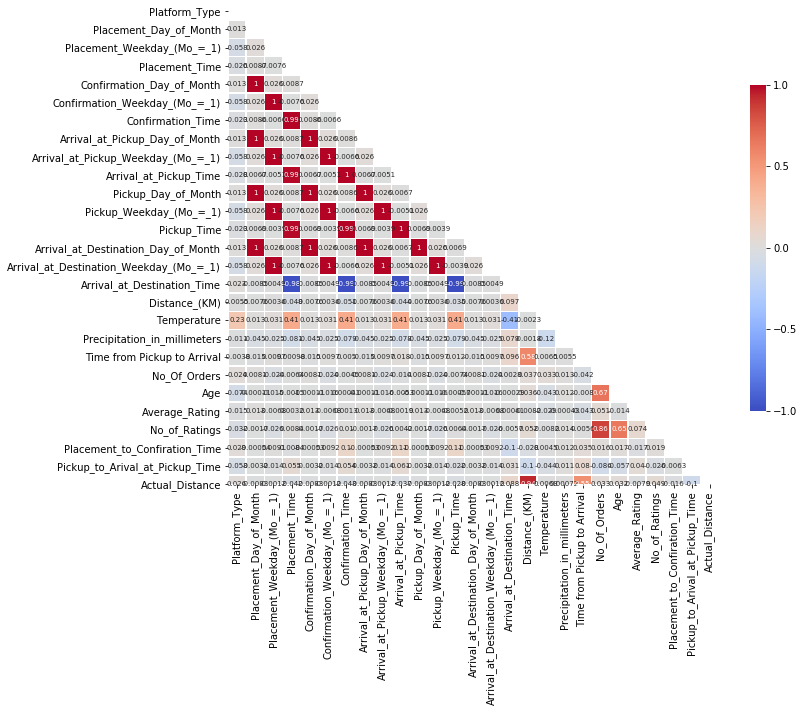

In [65]:
f, ax = plt.subplots(figsize=(11, 15))

heatmap = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 7})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})